(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Analyzing Hotel Ratings on Tripadvisor

In this homework we will focus on practicing two techniques: web scraping and regression. For the first part, we will get some basic information for each hotel in Boston. Then, we will fit a regression model on this information and try to analyze it.

** Task 1 (30 pts)**

We will scrape the data using Beautiful Soup. For each hotel that our search returns, we will get the information below.

![Information to be scraped](hotel_info.png)

Of course, feel free to collect even more data if you want. 

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

from BeautifulSoup import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import sys
import time
import os
import logging
import argparse
import requests
import codecs
import json
import re

base_url = "http://www.tripadvisor.com"
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.76 Safari/537.36"


city = 'Boston'
state = 'Massachusetts'
datadir = 'data'

log = logging.getLogger("logname60")
log.setLevel(logging.ERROR)
log.setLevel(logging.DEBUG)
loghandler = logging.StreamHandler(sys.stderr)
loghandler.setFormatter(logging.Formatter("[%(asctime)s] %(message)s"))
log.addHandler(loghandler)
# file to write the review data
f = open("reviews.txt", "w")

""" STEP 1  """
def get_tourism_page(city, state):
	""" 
		Return the json containing the
		URL of the tourism city page
	"""

	url = "%s/TypeAheadJson?query=%s%%20%s&action=API" % (base_url, "%20".join(city.split()), state)
	log.info("URL 	TO REQUEST: %s \n" % url)
	
	# Given the url, request the HTML page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')


	# Parse json to get url
	js = json.loads(html)
	results = js['results']
	log.info("RESULTS: %s \n " % results[0])
	urls = results[0]['urls'][0]
	log.info("URLS: %s \n " % urls)

	# get tourism page url
	tourism_url = urls['url']
	log.info("TOURISM PAGE URL: %s \n" % tourism_url)
	return tourism_url

""" STEP 2  """
def get_city_page(tourism_url):
	""" 
		Get the URL of the hotel 'omni parker'
		using the URL returned by the function
		get_tourism_page()
	"""

	url = base_url + tourism_url

	# Given the url, request the HTML page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')


	# Use BeautifulSoup to extract the url for the list of hotels in 
	# the city and state we are interested in.
	# For exampel in this case we need to  
	#<li class="hotels twoLines">
	#<a href="/Hotels-g60745-Boston_Massachusetts-Hotels.html" data-trk="hotels_nav"
	soup = BeautifulSoup(html)
	li = soup.find("li", {"class": "hotels twoLines"})
	city_url = li.find('a', href = True)
	log.info("CITY PAGE URL: %s" % city_url['href'])
	return city_url['href']


""" STEP 3 """
def get_hotellist_page(city_url):
	""" Get the hotel list page given the url returned by
		get_city_page(). Return the html after saving
		it to the datadir 
	"""

	url = base_url + city_url
	# Sleep 2 sec before starting a new http request
	time.sleep(2)
	# Request page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')
	# find the link for the Omni Parker Hotel by id        
	soup = BeautifulSoup(html)
	li = soup.find("div", {"id": "hotel_89599"})
	hotel_url = li.find('a', href = True)
	log.info("Hotel PAGE URL: %s" % hotel_url['href'])
	return hotel_url['href']
	#return html

def get_review_page(hotel_url):
	url = base_url + hotel_url
	# Sleep 2 sec before starting a new http request
	time.sleep(2)
	# Request page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')
	return html



""" STEP 4 """
def parse_hotellist_page(html):
	""" Parse the html pages returned by get_hotellist_page().
		Return the next url page to scrape (a city can have
		more than one page of hotels) if there is, else exit
		the script.
    """
	soup = BeautifulSoup(html)
	hotel_boxes = soup.findAll('div', {'class' :'reviewSelector  '})
	# searching for all the reviews url in the page and calling a function 'reviews rating' to scrap data off it
	for hotel_box in hotel_boxes:
		try:
			rurl = hotel_box.find('a',href = True)
			reviews=reviews_rating(rurl['href'])
		except Exception, e:
			log.error("No ratings for this review")        
        

# # Get next URL page if exists, else exit
	div = soup.find("div", {"class" : "unified pagination "})
	# check if last page
	if div.find('span', {'class' : 'nav next disabled'}):
		log.info("We reached last page")
		f.close()
		sys.exit()
	# If it is not las page there must be the Next URL
	hrefs = div.findAll('a', href= True)
	for href in hrefs:
		if href.find(text = True) == 'Next':
			log.info("Next url is %s" % href['href'])
			#f.close()
			return href['href']

        
def reviews_rating(rurl):
	url = base_url + rurl
	# Sleep 2 sec before starting a new http request
	time.sleep(2)
	# Request page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')
	soup = BeautifulSoup(html)
	review_box = soup.find('div', {'class' :'innerBubble'})

	Service = 'N/A'
	Cleanliness = 'N/A'
	Check = 'N/A'
	Value = 'N/A'
	Sleep = 'N/A'
	Rooms = 'N/A'
	Location = 'N/A'
	# finding the review box with the id and then scrap all the review ratings    
	try:
		review_id = review_box.find('p',{ 'id' : True })
		ratings = review_box.findAll('li', {'class' :'recommend-answer'})
		for rating in ratings:
			col = rating.find('div', {'class' :'recommend-description'}).find(text=True) 
			if col == 'Service' :            
				Service = rating.find("img")
				Service = Service['alt'].split()[0] 
			if col == 'Cleanliness' :            
				Cleanliness = rating.find("img")
				Cleanliness = Cleanliness['alt'].split()[0]
			if col == 'Value' :            
				Value = rating.find("img")
				Value = Value['alt'].split()[0]
			if col == 'Sleep Quality' :            
				Sleep = rating.find("img")
				Sleep = Sleep['alt'].split()[0]
			if col == 'Rooms' :            
				Rooms = rating.find("img")
				Rooms = Rooms['alt'].split()[0]
			if col == 'Location' :            
				Location = rating.find("img")
				Location = Location['alt'].split()[0]

		log.info(review_id['id'] + ":Value: %s " % Value)
		f.write(review_id['id'] + ":Value: %s " % Value + "\n")
		log.info(review_id['id'] + ":Location: %s " % Location)
		f.write(review_id['id'] + ":Location: %s " % Location + "\n")
		log.info(review_id['id'] + ":Sleep Quality: %s " % Sleep)
		f.write(review_id['id'] + ":Sleep Quality: %s " % Sleep + "\n")
		log.info(review_id['id'] + ":Rooms: %s " % Rooms)
		f.write(review_id['id'] + ":Rooms: %s " % Rooms + "\n")
		log.info(review_id['id'] + ":Cleanliness: %s " % Cleanliness)
		f.write(review_id['id'] + ":Cleanliness: %s " % Cleanliness + "\n")
		log.info(review_id['id'] + ":Service: %s \n" % Service)
		f.write(review_id['id'] + ":Service: %s " % Service + "\n\n")
	except Exception, e:
		log.error("No ratings for this review")
if __name__ == "__main__":

	# Get current directory
	current_dir = os.getcwd()

	# Create datadir if does not exist
	if not os.path.exists(os.path.join(current_dir, datadir)):
		os.makedirs(os.path.join(current_dir, datadir))
    
    # Obtain the url of the toursim page 
	tourism_url = get_tourism_page(city, state)
	#Get URL to obtaint the hotel Omni Parker
	city_url = get_city_page(tourism_url)
	#Get URL to obtain the reviews for the hotel    
	hotel_url = get_hotellist_page(city_url)

	#Loop to go to the next pages of the review
	c=0
	while(True):
		c +=1
		html = get_review_page(hotel_url)
		hotel_url = parse_hotellist_page(html)



[2016-03-29 04:38:12,802] URL 	TO REQUEST: http://www.tripadvisor.com/TypeAheadJson?query=Boston%20Massachusetts&action=API 

[2016-03-29 04:38:13,819] RESULTS: {u'lookbackServlet': None, u'name': u'Boston, Massachusetts, United States', u'data_type': u'LOCATION', u'title': u'Destinations', u'url': u'/Tourism-g60745-Boston_Massachusetts-Vacations.html', u'value': 60745, u'coords': u'42.357277,-71.05834', u'urls': [{u'url': u'/Tourism-g60745-Boston_Massachusetts-Vacations.html', u'type': u'GEO', u'name': u'Boston Tourism', u'url_type': u'geo'}], u'scope': u'global', u'type': u'GEO'} 
 
[2016-03-29 04:38:13,821] URLS: {u'url': u'/Tourism-g60745-Boston_Massachusetts-Vacations.html', u'type': u'GEO', u'name': u'Boston Tourism', u'url_type': u'geo'} 
 
[2016-03-29 04:38:13,824] TOURISM PAGE URL: /Tourism-g60745-Boston_Massachusetts-Vacations.html 

[2016-03-29 04:38:14,784] CITY PAGE URL: /Hotels-g60745-Boston_Massachusetts-Hotels.html
[2016-03-29 04:38:19,426] Hotel PAGE URL: /Hotel_Review

Above I'm extracting all the review data for Omni Parker Hotel. First I'm getting the tourism page of boston from there I'm getting the Hotel page followed by the Omni Parker Hotel Page. From the hotel page I'm collecting all the URL for every different review and passing it to a function which will get the review page and using Beautifulsoup it will extract the review Id and the ratings the user has given for all the reviews. Here I'm just taking the rating for 6 attributes, namely Rooms, Location, Value, Sleep Quality, Cleanliness and Service. I'm writing this data to a text file named "reviews.txt" from which I'll read latter to calculate the average ratings for this hotel, which I have uploaded as well. Above you can see the log entry of the data being scraped, the complete log will not print here as it is too long. The data file attached has all the reviews scraped.


In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

from BeautifulSoup import BeautifulSoup
import sys
import time
import os
import logging
import argparse
import requests
import codecs
import json
import pandas as pd

base_url = "http://www.tripadvisor.com"
user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.76 Safari/537.36"

trating = {}
city = 'Boston'
state = 'Massachusetts'
datadir = 'data'

log = logging.getLogger("logname57")
log.setLevel(logging.ERROR)
log.setLevel(logging.DEBUG)
loghandler = logging.StreamHandler(sys.stderr)
loghandler.setFormatter(logging.Formatter("[%(asctime)s] %(message)s"))
log.addHandler(loghandler)
#Open file to write all the rating summary onto it
f = open("boston.txt", "w")
data = []
namel = []
avgratingl = []
excellentl = []
verygoodl = []
poorl = []
terriblel = []
averagel = []
familyl = []
solol = []
friendl = []
couplel = []
businessl = []
totall = []
df = pd.DataFrame()

""" STEP 1  """
def get_tourism_page(city, state):
	""" 
		Return the json containing the
		URL of the tourism city page
	"""

	url = "%s/TypeAheadJson?query=%s%%20%s&action=API" % (base_url, "%20".join(city.split()), state)
	log.info("URL 	TO REQUEST: %s \n" % url)
	
	# Given the url, request the HTML page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')
	
	# Parse json to get url
	js = json.loads(html)
	results = js['results']
	log.info("RESULTS: %s \n " % results[0])
	urls = results[0]['urls'][0]
	log.info("URLS: %s \n " % urls)

	# get tourism page url
	tourism_url = urls['url']
	log.info("TOURISM PAGE URL: %s \n" % tourism_url)
	return tourism_url

""" STEP 2  """
def get_city_page(tourism_url):
	""" 
		Get the URL of the hotels of the city
		using the URL returned by the function
		get_tourism_page()
	"""

	url = base_url + tourism_url

	# Given the url, request the HTML page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')
	

	# Use BeautifulSoup to extract the url for the list of hotels in Boston

	#<a href="/Hotels-g60745-Boston_Massachusetts-Hotels.html" data-trk="hotels_nav"
	soup = BeautifulSoup(html)
	li = soup.find("li", {"class": "hotels twoLines"})
	city_url = li.find('a', href = True)
	log.info("CITY PAGE URL: %s" % city_url['href'])
	return city_url['href']


""" STEP 3 """
def get_hotellist_page(city_url, count):
	""" Get the hotel list page given the url returned by
		get_city_page(). Return the html.
	"""

	url = base_url + city_url
	# Sleep 2 sec before starting a new http request
	time.sleep(2)
	# Request page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')

	return html
	

""" STEP 4 """
def parse_hotellist_page(html):
	""" Parse the html pages returned by get_hotellist_page().
		Return the next url page to scrape (a city can have
		more than one page of hotels) if there is, else exit
		the script.
	"""
    
	soup = BeautifulSoup(html)
# Extract hotel name and Hotel URL to pass to another function traveller_rating 
	hotel_boxes = soup.findAll('div', {'class' :'listing easyClear  p13n_imperfect '})
	for hotel_box in hotel_boxes:
		name = hotel_box.find('div', {'class' :'listing_title'}).find(text=True)
		hurl = hotel_box.find('a',href = True)
		trating=traveller_rating(name,hurl['href'])

# # Get next URL page if exists, else exit
	div = soup.find("div", {"class" : "unified pagination standard_pagination"})
	# check if last page
	if div.find('span', {'class' : 'nav next ui_button disabled'}):
		log.info("We reached last page")
		f.close()    
		sys.exit()
	# If it is not las page there must be the Next URL
	hrefs = div.findAll('a', href= True)
	for href in hrefs:
		if href.find(text = True) == 'Next':
			log.info("Next url is %s" % href['href'])
			return href['href']

def traveller_rating(name,hurl):
	url = base_url + hurl
	# Sleep 2 sec before starting a new http request
	time.sleep(2)
	# Request page
	headers = { 'User-Agent' : user_agent }
	response = requests.get(url, headers=headers)
	html = response.text.encode('utf-8')
	soup = BeautifulSoup(html)
	if soup != 'N/A':
	# Extracting reviews rating, no. of reviews and the type of reviews 
		try:
			excellent = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_5'}).findAll('span')[2].find(text=True)
			verygood = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_4'}).findAll('span')[2].find(text=True)
			average = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_3'}).findAll('span')[2].find(text=True)
			poor = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_2'}).findAll('span')[2].find(text=True)
			terrible = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterRating_1'}).findAll('span')[2].find(text=True)
			Families = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Family'}).find('span').find(text=True)
			Families = Families.replace('(',"").replace(')',"").replace(',',"")            
			Couples = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Couples'}).find('span').find(text=True)
			Couples = Couples.replace('(',"").replace(')',"").replace(',',"")  
			Solo = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Solo'}).find('span').find(text=True)
			Solo = Solo.replace('(',"").replace(')',"").replace(',',"")  
			Business = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Business'}).find('span').find(text=True)
			Business = Business.replace('(',"").replace(')',"").replace(',',"")  
			Friends = soup.find('label', {'for':'taplc_prodp13n_hr_sur_review_filter_controls_0_filterSegment_Friends'}).find('span').find(text=True)
			Friends = Friends.replace('(',"").replace(')',"").replace(',',"")  
		except Exception, e:
			log.error("No ratings for this hotel")
	# writing reviews rating, no. of reviews and the type of reviews to the file and log 
		log.info("HOTEL NAME: %s" % name)
		f.write("HOTEL NAME: %s" % name + "\n")
		log.info("Excellent REVIEWS: %s" % excellent)
		f.write("Excellent REVIEWS: %s" % excellent + "\n")
		log.info("Very Good REVIEWS: %s " % verygood)
		f.write("Very Good REVIEWS: %s " % verygood + "\n")
		log.info("Average REVIEWS: %s " % average)
		f.write("Average REVIEWS: %s " % average + "\n")
		log.info("Poor REVIEWS: %s" % poor)
		f.write("Poor REVIEWS: %s" % poor + "\n")
		log.info("Terrible REVIEWS: %s " % terrible)
		f.write("Terrible REVIEWS: %s " % terrible + "\n")
		log.info("Family REVIEWS: %s " % Families)
		f.write("Family REVIEWS: %s " % Families + "\n")
		log.info("Couple REVIEWS: %s " % Couples)
		f.write("Couple REVIEWS: %s " % Couples + "\n")
		log.info("Solo REVIEWS: %s " % Solo)
		f.write("Solo REVIEWS: %s " % Solo + "\n")
		log.info("Business REVIEWS: %s " % Business)
		f.write("Business REVIEWS: %s " % Business + "\n")
		log.info("Friends REVIEWS: %s " % Friends)
		f.write("Friends REVIEWS: %s " % Friends + "\n")
    
	# calculating total and average of reviews and appending it to lists 
		totalrating = float((int(excellent.replace(',',"")) + int(verygood.replace(',',"")) + int(average.replace(',',"")) + int(poor.replace(',',"")) + int(terrible.replace(',',""))))     
		avgrating = (int(excellent.replace(',',""))*5+int(verygood.replace(',',""))*4+int(average.replace(',',""))*3+int(poor.replace(',',""))*2+int(terrible.replace(',',""))*1)/totalrating
		log.info("Average Review Rating: %f \n" % avgrating)
		f.write("Average Review Rating: %f \n" % avgrating + "\n")
		namel.append(name)
	# appending the type of reviews and no. of excellent reviews to lists
		avgratingl.append(avgrating)
		excellentl.append(int(excellent.replace(',',"")))
		familyl.append(Families)
		couplel.append(Couples)
		solol.append(Solo)
		businessl.append(Business)
		friendl.append(Friends)
		totall.append(totalrating)

		verygoodl.append(int(verygood.replace(',',"")))
		averagel.append(int(average.replace(',',"")))
		poorl.append(int(poor.replace(',',"")))
		terriblel.append(int(terrible.replace(',',"")))        

if __name__ == "__main__":

	# Get current directory
	current_dir = os.getcwd()

	# Create datadir if does not exist
	if not os.path.exists(os.path.join(current_dir, datadir)):
		os.makedirs(os.path.join(current_dir, datadir))
    
    # Obtain the url of the toursim page 
	tourism_url = get_tourism_page(city, state)
	#Get URL to obtaint the list of hotels in a specific city
	city_url = get_city_page(tourism_url)
	# loop to run through different pages     
	c=0
	while(True):
		c +=1
		html = get_hotellist_page(city_url,c)
		city_url = parse_hotellist_page(html)


[2016-03-29 21:53:27,513] URL 	TO REQUEST: http://www.tripadvisor.com/TypeAheadJson?query=Boston%20Massachusetts&action=API 

[2016-03-29 21:53:28,245] RESULTS: {u'lookbackServlet': None, u'name': u'Boston, Massachusetts, United States', u'data_type': u'LOCATION', u'title': u'Destinations', u'url': u'/Tourism-g60745-Boston_Massachusetts-Vacations.html', u'value': 60745, u'coords': u'42.357277,-71.05834', u'urls': [{u'url': u'/Tourism-g60745-Boston_Massachusetts-Vacations.html', u'type': u'GEO', u'name': u'Boston Tourism', u'url_type': u'geo'}], u'scope': u'global', u'type': u'GEO'} 
 
[2016-03-29 21:53:28,246] URLS: {u'url': u'/Tourism-g60745-Boston_Massachusetts-Vacations.html', u'type': u'GEO', u'name': u'Boston Tourism', u'url_type': u'geo'} 
 
[2016-03-29 21:53:28,247] TOURISM PAGE URL: /Tourism-g60745-Boston_Massachusetts-Vacations.html 

[2016-03-29 21:53:28,965] CITY PAGE URL: /Hotels-g60745-Boston_Massachusetts-Hotels.html
[2016-03-29 21:53:36,242] HOTEL NAME: Omni Parker House

SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


Above I'm extracting data for all the hotels in Boston, MA. Using the same basic fuctions I'm getting the tourism page followed by the hotel list page. Here I'm extracting all the URLs for all the different 82 hotels and passing it to a function which in turn uses BeautifulSoup to extract data from the hotel page. I'm extracting the number of different types ratings like excellent, very good, average, poor and terrible. I'm also extracting the number of different review caterogie like family, couple, Solo, Business and friends. I'm calculating the average traveller's rating and writing all of this data to a file called "boston.txt" which I've uploaded as well. Above is the log of the running code, the last line tells us that we have recahed the last page. 

** Task 2 (20 pts) **

Now, we will use regression to analyze this information. First, we will fit a linear regression model that predicts the average rating. For example, for the hotel above, the average rating is

$$ \text{AVG_SCORE} = \frac{1*31 + 2*33 + 3*98 + 4*504 + 5*1861}{2527}$$

Use the model to analyze the important factors that decide the $\text{AVG_SCORE}$.

In [2]:
import pandas as pd
data ={"Name":namel,"Average RR":avgratingl,"Family":map(int,familyl),"Couple":map(int,couplel),"Business":map(int,businessl),"Friends":map(int,friendl),"Solo":map(int,solol)}
df['Name'] = df['Name'].apply(lambda x:str(x).replace('/',''))

s1=0
s2=0
s3=0
s4=0
s5=0
namelist = []
ser_avg = []
clean_avg = []
val_avg = []
sle_avg = []
room_avg = []
local_avg = []

# reading the file provided to us 
# In every line of the file I'm searching for the hotel names that I got from above code
# I'm calculating the number of different types of ratings by seaching for them in a loop
with open('rating-summary.dat', 'r') as filedata:
    for line in filedata:
        for name in df['Name']:
            if name in line:
                if name + ":Service:1" in line:
                     s1 = line.split(':')[3]
                if name + ":Service:2" in line:
                     s2 = line.split(':')[3]
                if name + ":Service:3" in line:
                     s3 = line.split(':')[3]      
                if name + ":Service:4" in line:
                     s4 = line.split(':')[3]
                if name + ":Service:5" in line:
                     s5 = line.split(':')[3]
                     service_avg = (int(s1) * 1 + int(s2) * 2 + int(s3) * 3 + int(s4) * 4 + int(s5) * 5)/float(int(s1) + int(s2) + int(s3) + int(s4) + int (s5))
                     namelist.append(name)
                     ser_avg.append(service_avg)   
                if name + ":Cleanliness:1" in line:
                     s1 = line.split(':')[3]
                if name + ":Cleanliness:2" in line:
                     s2 = line.split(':')[3]
                if name + ":Cleanliness:3" in line:
                     s3 = line.split(':')[3]      
                if name + ":Cleanliness:4" in line:
                     s4 = line.split(':')[3]
                if name + ":Cleanliness:5" in line:
                     s5 = line.split(':')[3]
                     Cleanliness_avg = (int(s1) * 1 + int(s2) * 2 + int(s3) * 3 + int(s4) * 4 + int(s5) * 5)/float(int(s1) + int(s2) + int(s3) + int(s4) + int (s5))
                     clean_avg.append(Cleanliness_avg)
                if name + ":Value:1" in line:
                     s1 = line.split(':')[3]
                if name + ":Value:2" in line:
                     s2 = line.split(':')[3]
                if name + ":Value:3" in line:
                     s3 = line.split(':')[3]      
                if name + ":Value:4" in line:
                     s4 = line.split(':')[3]
                if name + ":Value:5" in line:
                     s5 = line.split(':')[3]
                     Value_avg = (int(s1) * 1 + int(s2) * 2 + int(s3) * 3 + int(s4) * 4 + int(s5) * 5)/float(int(s1) + int(s2) + int(s3) + int(s4) + int (s5))
                     val_avg.append(Value_avg)
                if name + ":Sleep Quality:1" in line:
                     s1 = line.split(':')[3]
                if name + ":Sleep Quality:2" in line:
                     s2 = line.split(':')[3]
                if name + ":Sleep Quality:3" in line:
                     s3 = line.split(':')[3]      
                if name + ":Sleep Quality:4" in line:
                     s4 = line.split(':')[3]
                if name + ":Sleep Quality:5" in line:
                     s5 = line.split(':')[3]
                     Sleep_avg = (int(s1) * 1 + int(s2) * 2 + int(s3) * 3 + int(s4) * 4 + int(s5) * 5)/float(int(s1) + int(s2) + int(s3) + int(s4) + int (s5))
                     sle_avg.append(Sleep_avg)
                if name + ":Rooms:1" in line:
                     s1 = line.split(':')[3]
                if name + ":Rooms:2" in line:
                     s2 = line.split(':')[3]
                if name + ":Rooms:3" in line:
                     s3 = line.split(':')[3]      
                if name + ":Rooms:4" in line:
                     s4 = line.split(':')[3]
                if name + ":Rooms:5" in line:
                     s5 = line.split(':')[3]
                     Rooms_avg = (int(s1) * 1 + int(s2) * 2 + int(s3) * 3 + int(s4) * 4 + int(s5) * 5)/float(int(s1) + int(s2) + int(s3) + int(s4) + int (s5))
                     room_avg.append(Rooms_avg)
                if name + ":Location:1" in line:
                     s1 = line.split(':')[3]
                if name + ":Location:2" in line:
                     s2 = line.split(':')[3]
                if name + ":Location:3" in line:
                     s3 = line.split(':')[3]      
                if name + ":Location:4" in line:
                     s4 = line.split(':')[3]    
                if name + ":Location:5" in line:
                     s5 = line.split(':')[3]
                     Location_avg = (int(s1) * 1 + int(s2) * 2 + int(s3) * 3 + int(s4) * 4 + int(s5) * 5)/float(int(s1) + int(s2) + int(s3) + int(s4) + int (s5))
                     local_avg.append(Location_avg)
#                         
                if "Element Boston Seaport:Value:5:1" in line:
                     local_avg.append(4)
# writing all the data to a dataframe                        
data2 ={"Name":namelist,"Service":ser_avg,"Cleanliness":clean_avg,"Value":val_avg,"Sleep Quality":sle_avg,"Rooms":room_avg,"Location":local_avg}
df2 = pd.DataFrame.from_records(data2)

service_review = 0
Cleanliness_review = 0
Value_review = 0
Sleep_review = 0
Rooms_review = 0
Location_review = 0

# calulating the number od diffrent types of reviews for the omni parker hotel from the file that I saved earlier
# computing the average rating for this hotel
with open('reviews.txt', 'r') as filedata2:
    counter = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for line2 in filedata2:
        for i in range(1,6):
            if ":Service: "+ str(i) in line2:
                if i == 1:
                    counter = counter + 1
                if i == 2:
                    counter2 = counter2 + 1
                if i == 3:
                    counter3 = counter3 + 1
                if i == 4:
                    counter4 = counter4 + 1
                if i == 5:
                    counter5 = counter5 + 1
              
    service_review = (counter*1+counter2*2+counter3*3+counter4*4+counter5*5)/float(counter+counter2+counter3+counter4+counter5)
   
    
with open('reviews.txt', 'r') as filedata2:
    counter = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for line2 in filedata2:
        for i in range(1,6):
            if ":Value: "+ str(i) in line2:
                if i == 1:
                    counter = counter + 1
                if i == 2:
                    counter2 = counter2 + 1
                if i == 3:
                    counter3 = counter3 + 1
                if i == 4:
                    counter4 = counter4 + 1
                if i == 5:
                    counter5 = counter5 + 1
              
    Value_review = (counter*1+counter2*2+counter3*3+counter4*4+counter5*5)/float(counter+counter2+counter3+counter4+counter5)
  
    
with open('reviews.txt', 'r') as filedata2:
    counter = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for line2 in filedata2:
        for i in range(1,6):
            if ":Location: "+ str(i) in line2:
                if i == 1:
                    counter = counter + 1
                if i == 2:
                    counter2 = counter2 + 1
                if i == 3:
                    counter3 = counter3 + 1
                if i == 4:
                    counter4 = counter4 + 1
                if i == 5:
                    counter5 = counter5 + 1
              
    Location_review = (counter*1+counter2*2+counter3*3+counter4*4+counter5*5)/float(counter+counter2+counter3+counter4+counter5)
  
    
with open('reviews.txt', 'r') as filedata2:
    counter = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for line2 in filedata2:
        for i in range(1,6):
            if ":Sleep Quality: "+ str(i) in line2:
                if i == 1:
                    counter = counter + 1
                if i == 2:
                    counter2 = counter2 + 1
                if i == 3:
                    counter3 = counter3 + 1
                if i == 4:
                    counter4 = counter4 + 1
                if i == 5:
                    counter5 = counter5 + 1
              
    Sleep_review = (counter*1+counter2*2+counter3*3+counter4*4+counter5*5)/float(counter+counter2+counter3+counter4+counter5)
  
    
with open('reviews.txt', 'r') as filedata2:
    counter = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for line2 in filedata2:
        for i in range(1,6):
            if ":Rooms: "+ str(i) in line2:
                if i == 1:
                    counter = counter + 1
                if i == 2:
                    counter2 = counter2 + 1
                if i == 3:
                    counter3 = counter3 + 1
                if i == 4:
                    counter4 = counter4 + 1
                if i == 5:
                    counter5 = counter5 + 1
              
    Rooms_review = (counter*1+counter2*2+counter3*3+counter4*4+counter5*5)/float(counter+counter2+counter3+counter4+counter5)
   
    
with open('reviews.txt', 'r') as filedata2:
    counter = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for line2 in filedata2:
        for i in range(1,6):
            if ":Cleanliness: "+ str(i) in line2:
                if i == 1:
                    counter = counter + 1
                if i == 2:
                    counter2 = counter2 + 1
                if i == 3:
                    counter3 = counter3 + 1
                if i == 4:
                    counter4 = counter4 + 1
                if i == 5:
                    counter5 = counter5 + 1
              
    Cleanliness_review = (counter*1+counter2*2+counter3*3+counter4*4+counter5*5)/float(counter+counter2+counter3+counter4+counter5)
# appending this hotel data to the dataframe that has all the other hotels 
data3 ={"Name":'Omni Parker House',"Service":service_review,"Cleanliness":Cleanliness_review,"Value":Value_review,"Sleep Quality":Sleep_review,"Rooms":Rooms_review,"Location":Location_review}
df3 = df2.append(data3,ignore_index=True)
# merge the data frame which has the reviews rating with dataframe that has the hotel average rating on hotel name
df4 = pd.merge(df, df3, on='Name')
df4

,Average RR,Business,Couple,Family,Friends,Name,Solo,Cleanliness,Location,Rooms,Service,Sleep Quality,Value
0,4.145529,1322,1753,1156,421,Omni Parker House,282,4.439198,4.820921,3.872856,4.416090,4.183654,3.928815
1,4.164684,454,458,355,84,Hyatt Regency Boston Harbor,132,4.498799,4.383691,4.291457,4.352044,4.331412,3.871176
2,4.676060,1568,770,601,197,Seaport Boston Hotel,123,4.827046,4.604000,4.673224,4.734213,4.711824,4.330104
3,4.739416,702,1016,1110,208,Hotel Commonwealth,168,4.872434,4.765221,4.791056,4.804683,4.750316,4.409108
4,4.238235,920,573,673,197,The Westin Copley Place,113,4.443006,4.806156,4.290994,4.279339,4.497455,3.863476
5,4.390578,403,754,533,309,Revere Hotel Boston Common,91,4.598225,4.727111,4.494197,4.485714,4.426230,4.152461
6,4.080365,410,247,238,93,Sheraton Boston Hotel,36,4.364286,4.615776,4.045226,4.194748,4.286472,3.840647
7,4.467827,664,851,527,192,InterContinental Boston,137,4.737288,4.574160,4.606187,4.425685,4.482659,4.041619
8,4.539892,373,915,381,156,Nine Zero Hotel - a Kimpton Hotel,123,4.681500,4.826860,4.485314,4.614815,4.584691,4.168889
9,4.707746,294,524,327,78,Boston Harbor Hotel,64,4.824275,4.818182,4.701031,4.800151,4.710259,4.265269


Above I'm calulating the average review ratings from the file provided to us and from the Omni parker file that I wrote in the previous task and appending the data to a single data frame. 
For 'Element Boston Seaport Hotel' there is rating for location tag, As reading the reviews I found pretty good feedback on location, I have given that hotel location tag a value of 4.
Finally I merged both the data frame to get a dataframe with the hotel name, average rating and the different review ratings.

In [8]:
import statsmodels.api as sm
import pandas as pd

X = df4[['Service','Cleanliness','Value','Sleep Quality','Rooms','Location','Friends','Family','Solo','Business','Couple']]
Y = df4[['Average RR']]

regresion = sm.OLS(Y, X)
output = regresion.fit()
print(output.summary())

                            OLS Regression Results                            
Dep. Variable:             Average RR   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.888e+04
Date:                Tue, 29 Mar 2016   Prob (F-statistic):          2.22e-118
Time:                        23:44:25   Log-Likelihood:                 94.472
No. Observations:                  82   AIC:                            -166.9
Df Residuals:                      71   BIC:                            -140.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Service           0.1592      0.079      2.027

Above we have the output for the linear regression model :
Number of variables are 11 and the number of observations are 82. As the number of observations are too less for the nmber of variable here, hence the fit of the model is overfit and we get r squared value as 1.

The various types of ratings have much more effect on the average rating than the types of users rating, which makes sense, however, we can see that on average, couples appear to rate Boston hotels slightly more highly than friends and solo travelers. Business and Family travelers' effect is pretty much close to zero.

Among the types of ratings, the Rooms rating have the most impact by a huge margin, followed by Service, Cleanliness, Value, Location and the least impact amonge the types is caused by Sleep Quality. It makes sense that Sleep Quality  have the lowest impact, as Sleep Quality rating is highly subjective. When looking at hotels in Boston, Location would seem to be of relatively little importance with the wide availability of public transit as well as all being within the city limits.

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value indicates that you can reject the null hypothesis. Over here we can see that Rooms and Location have a p-values almost zero, indicating that they are very important factors. On the other hand number of Family reviews, Business reviews and Sleep Quality have a very large p-value indicating that they are not significate contributers to the result.

** Task 3 (30 pts) **

Finally, we will use logistic regression to decide if a hotel is _excellent_ or not. We classify a hotel as _excellent_ if more than **60%** of its ratings are 5 stars. This is a binary attribute on which we can fit a logistic regression model. As before, use the model to analyze the data.

In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
# calculating the excellent rating percentage 
percentl = [(float(a) / float(b))*100 for a,b in zip(excellentl, totall)]

# putting data into a data frame
data4 ={"Name":namel,"Excellent Ratings":excellentl,"Total Ratings":totall,"% Excellent Rating":percentl}
df10 = pd.DataFrame.from_records(data4)

# function to determine weather percentage of excellent rating is greater than 60 or not
def excellent_label (row):
    if row['% Excellent Rating'] > 60 :
        return 1
    if row['% Excellent Rating'] <=60 :
        return 0
# inserting a new column to have the binary variable passed on the excellent rating percentage 
df10['Excellent'] = df10.apply (lambda row: excellent_label (row),axis=1)
df10

,% Excellent Rating,Excellent Ratings,Name,Total Ratings,Excellent
0,46.670408,2495,Omni Parker House,5346,0
1,46.462116,742,Hyatt Regency Boston Harbor,1597,0
2,76.409064,2630,Seaport Boston Hotel,3442,1
3,80.892449,2828,Hotel Commonwealth,3496,1
4,48.382353,1316,The Westin Copley Place,2720,0
5,56.316916,1315,Revere Hotel Boston Common,2335,0
6,38.721461,424,Sheraton Boston Hotel,1095,0
7,64.265480,1588,InterContinental Boston,2471,1
8,66.030348,1349,Nine Zero Hotel - a Kimpton Hotel,2043,1
9,79.507042,1129,Boston Harbor Hotel,1420,1


Above I've got the total number of reviews and the number of excellent reviews. I'm calculating the percentage of excellent reviews and assigning a binary variable 1 or 0 based on the percentage of excellent reviews. If greater than 60% than the binary variable 'excellent' is 1 otherwise 0. 
Finally we a table above with the hotel name, their excellent percentage score and the binary variable either 0 or 1.

Optimization terminated successfully.
         Current function value: 0.156556
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:              Excellent   No. Observations:                   82
Model:                          Logit   Df Residuals:                       70
Method:                           MLE   Df Model:                           11
Date:                Tue, 29 Mar 2016   Pseudo R-squ.:                  0.7362
Time:                        23:44:02   Log-Likelihood:                -12.838
converged:                       True   LL-Null:                       -48.660
                                        LLR p-value:                 5.941e-11
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Service          12.1095      7.171      1.689      0.091        -1.945    26.164
Cleanliness     -43

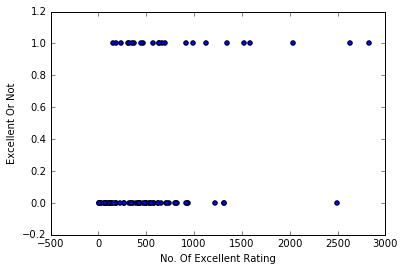

In [7]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
# giving the columns for training data set.
train_cols = df4[['Service','Cleanliness','Value','Sleep Quality','Rooms','Location','Friends','Family','Solo','Business','Couple','Average RR']] 
logit = sm.Logit(df10['Excellent'], train_cols)
result = logit.fit()
print (result.summary())
#plotting 
plt.scatter(df10['Excellent Ratings'],df10['Excellent'])
plt.xlabel('No. Of Excellent Rating')
plt.ylabel('Excellent Or Not')

Above we have the logistic regression table when we target to find the hotels with excellent ratings greater than 60% of the total ratings. Depandent variable here is "excellent". The Pseudo R-Squared value here is .736 which indicates that our model accounts for 73.6% of the variance of the dependant variable. From the table we can again see that the ratings having more impact on the result than the type of visitor review, which is understandable. The average review rating has the highest coef value here (39.17) which makes sense as the excellent output is calculated from the average rating, if the average is greater than 60 then excellent is 1.

Next we can see that the Rooms rating have the most effect on "excellency" than any other attribute as the coef is 20.6 . We can see this, as the room is the primary interaction a customer has with the hotel. Service is next as it has coef of 12.1, we can this as the service of any hotel is equally important with the Rooms.

The p-value for the types of visitor review ('business','solo','friends','family','couple') is very high especially for Solo (0.92) which indicate that they are not relevant to our result which is as excepted. Sleep Quality too has a pretty high p-value indicating that this rating is not that relevant which is what we got from linear regresion as well. On the other hand Average Ratings has the lowest p-value followed by cleanliness indicating that these are important factors.

Cleanliness, Location, Value and Sleep Quality actually shows a decrease in the likelihood of an hotel being excellent. This could be beacuse of the higher expectations associated with their extremely high ratings.

Finally I'm printing a plot that shows the numbers of excellent reviews on x and where it has 60% of reviews excellent or not in on y.

-------

In [9]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()